# Model a flowing non-viscous fluid using QUICK-PDE

{/* cspell:ignore edgecolor, royalblue, rstride, cstride, Navier */}

*Usage estimate: 50 minutes on `ibm_kingston`. (NOTE: This is an estimate only. Your runtime may vary.)*

Note that the execution time of this function is generally greater than 20 minutes,
so you might want to split this tutorial in two sections: the first one, in which
you read through it and launch the jobs, and the second one a few hours later
(giving ample time for the jobs to complete), to work with the results of the jobs.

## Background

This tutorial seeks to teach on an introductory level how to use the QUICK-PDE
function to solve complex multi-physics problems on 156Q Heron R2 QPUs by using
ColibriTD's H-DES (Hybrid Differential Equation Solver).
The underlying algorithm is described in [the H-DES paper.](https://arxiv.org/abs/2410.01130)
Note that this solver can also solve non-linear equations.

Multi-physics problems - including fluids dynamics, heat diffusion, and material
deformation, to name a few - can be ubiquitously described by Partial
Differential Equations (PDEs).

Such problems are highly relevant for various industries and constitute an
important branch of applied mathematics. However, solving non-linear
multivariate coupled PDEs with classical tools remains challenging due to the
requirement of an exponentially large amount of resources.

This function is appropriate for equations with increasing complexity and
variables, and is the first step to unlock possibilities that were once
considered intractable. To fully describe a problem modeled by PDEs, it is
necessary to know the initial and boundary conditions. These can strongly
change the solution of the PDE and the path to find their solution.

In this tutorial, you will learn how to:

1. Define the parameters of the initial condition function.
2. Adjust the qubit number (used to encode the function of the differential equation), depth, and shot number.
3. Run QUICK-PDE to solve the underlying differential equation.

## Requirements

Before starting this tutorial, be sure you have the following installed:

* Qiskit SDK v2.0 or later (`pip install qiskit`)
* Qiskit Functions Catalog (`pip install qiskit-ibm-catalog`)
* Matplotlib (`pip install matplotlib`)
* Access to the QUICK-PDE function. Fill out the [form to request access.](https://forms.office.com/e/kJzViZNVa4)

## Setup

Authenticate using your [API key](http://quantum.cloud.ibm.com/) and select the function as follows:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_catalog import QiskitFunctionsCatalog

catalog = QiskitFunctionsCatalog(
    channel="ibm_cloud / ibm_quantum / ibm_quantum_platform",
    instance="USER_CRN / HGP",
    token="USER_API_KEY / IQP_API_TOKEN",
)

quick = catalog.load("colibritd/quick-pde")

## Step 1: Set properties of the problem to solve

This tutorial covers the user experience from two perspectives: the
physical problem determined by the initial conditions, and the algorithmic
component in solving a fluid dynamics example on a quantum computer.

Computational Fluid Dynamics (CFD) has a broad range of applications, and thus it is
important to study and solve the underlying PDEs. An important family of PDEs
are the Navier-Stokes equations, which are a system of nonlinear partial
differential equations describing the motion of fluids. They are highly relevant
for scientific problems and engineering applications.

Under certain conditions, the Navier-Stokes equations reduce to Burgers'
equation, a convection–diffusion equation describing phenomena occurring in
fluid dynamics, gas dynamics, and nonlinear acoustics, to name a few, by modeling
dissipative systems.

The one-dimensional version of the equation depends on two variables:
$t \in \mathbb{R}_{\geq 0}$ modeling the temporal dimension, $x \in \mathbb{R}$
representing the spatial dimension. The general form of the equation is called
the viscous Burgers' equation and reads:

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial^2 x},$$

where $u(x,t)$ is the fluid speed field at a given position $x$ and time $t$, and $\nu$
is the viscosity of the fluid. Viscosity is an important property of a fluid
that measures its rate-dependent resistance to motion or deformation, and thus it
plays a crucial role in the determination of the dynamics of a fluid. When the
viscosity of the fluid is null ($\nu$ = 0), the equation becomes a conservation
equation that can develop discontinuities (shock waves), due to the lack of its
internal resistance. In this case, the equation is called the inviscid Burgers'
equation and is a special case of nonlinear wave equation.

Strictly speaking, inviscid flows do not occur in nature, but when modeling
aerodynamic flow, due to the infinitesimal effect of transport, using an
inviscid description of the problem can be useful. Surprisingly, more than
70% of aerodynamic theory deals with inviscid flows.

In this tutorial we offer the inviscid Burgers' equation as a CFD example to solve
on IBM&reg; QPUs using QUICK-PDE, given by the equation:
$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = 0, $$

The initial condition for this problem is set to a linear function:
$$u(t=0,x) = ax + b,\text{ with }a,b\in\mathbb{R}$$
where $a$ and $b$ are arbitrary constants influencing the shape of the
solution. You can adjust $a$ and $b$ and see how they influence the
solving process and the solution.

In [ ]:
job = quick.run(
    use_case="cfd",
    physical_parameters={"a": 1.0, "b": 1.0},
)

In [ ]:
print(job.result())

{'functions': {'u': array([[1.        , 0.96112378, 0.9230742 , 0.88616096, 0.85058445,
        0.81644741, 0.78376878, 0.75249908, 0.72253689, 0.69374562,
        0.66597013, 0.63905258, 0.61284684, 0.58723093, 0.56211691,
        0.53745752, 0.51324915, 0.48953036, 0.46637547, 0.44388257,
        0.4221554 , 0.40127848, 0.38128488, 0.36211604, 0.34357308,
        0.32525895, 0.30651089, 0.28632252, 0.26325504, 0.23533692],
       [1.2375    , 1.19267729, 1.14850734, 1.10544526, 1.06382155,
        1.02385326, 0.98565757, 0.94926734, 0.91464784, 0.88171402,
        0.85034771, 0.82041411, 0.79177677, 0.76431068, 0.73791248,
        0.71250742, 0.68805224, 0.66453346, 0.64196021, 0.62035121,
        0.59971506, 0.5800232 , 0.56117499, 0.54295419, 0.52497612,
        0.50662498, 0.48698059, 0.4647339 , 0.43809065, 0.40466247],
       [1.475     , 1.4242308 , 1.37394048, 1.32472956, 1.27705866,
        1.23125911, 1.18754636, 1.1460356 , 1.10675879, 1.06968242,
        1.03472529, 1.0017

## Step 2 (if needed): Optimize problem for quantum hardware execution

By default, the solver uses physically-informed parameters, which are initial circuit parameters for a given qubit number and depth from which our solver will start.

The shots are also part of the parameters with a default value, since fine-tuning them is important.

Depending on the configuration you're trying to solve, the algorithm's
parameters to achieve satisfactory solutions might need to be adapted; for example, it
can require more or fewer qubits per variable $t$ and $x$, depending on $a$ and
$b$. The following adjusts the number of qubits per function per
variable, the depth per function, and the number of shots.

You can also see how to specify the backend and the execution mode.

In addition, physically-informed parameters might steer the optimization process
in a wrong direction; in that case, you can disable it by setting the
`initialization` strategy to `"RANDOM"`.

In [ ]:
job_2 = quick.run(
    use_case="cfd",
    physical_parameters={"a": 0.5, "b": 0.25},
    nb_qubits={"u": {"t": 2, "x": 1}},
    depth={"u": 3},
    shots=[500, 2500, 5000, 10000],
    initialization="RANDOM",
    backend="ibm_kingston",
    mode="session",
)

In [ ]:
print(job_2.result())

{'functions': {'u': array([[0.25      , 0.24856543, 0.24687708, 0.2449444 , 0.24277686,
        0.24038389, 0.23777496, 0.23495952, 0.23194702, 0.22874691,
        0.22536866, 0.22182171, 0.21811551, 0.21425952, 0.2102632 ,
        0.20613599, 0.20188736, 0.19752675, 0.19306361, 0.18850741,
        0.18386759, 0.1791536 , 0.17437491, 0.16954096, 0.16466122,
        0.15974512, 0.15480213, 0.1498417 , 0.14487328, 0.13990632],
       [0.36875   , 0.36681313, 0.36457201, 0.36203594, 0.35921422,
        0.35611615, 0.35275103, 0.34912817, 0.34525687, 0.34114643,
        0.33680614, 0.33224532, 0.32747327, 0.32249928, 0.31733266,
        0.31198271, 0.30645873, 0.30077002, 0.29492589, 0.28893564,
        0.28280857, 0.27655397, 0.27018116, 0.26369944, 0.2571181 ,
        0.25044645, 0.24369378, 0.23686941, 0.22998264, 0.22304275],
       [0.4875    , 0.48506084, 0.48226695, 0.47912748, 0.47565158,
        0.47184841, 0.46772711, 0.46329683, 0.45856672, 0.45354594,
        0.44824363, 0.4426

## Step 3: Use the result

With your solution, you can now choose what to do with it. The following demonstrates how to plot the result.

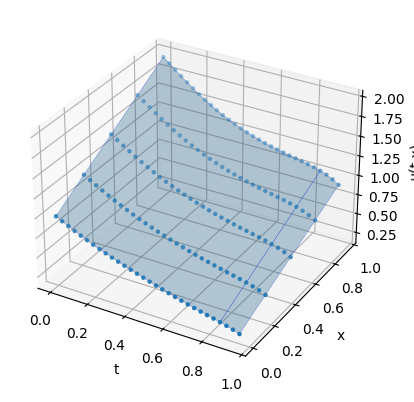

In [ ]:
solution = job.result()

# Plot the solution of the second simulation job_2
_ = plt.figure()
ax = plt.axes(projection="3d")

# plot the solution using the 3d plotting capabilities of pyplot
t, x = np.meshgrid(solution["samples"]["t"], solution["samples"]["x"])
ax.plot_surface(
    t,
    x,
    solution["functions"]["u"],
    edgecolor="royalblue",
    lw=0.25,
    rstride=26,
    cstride=26,
    alpha=0.3,
)
ax.scatter(t, x, solution, marker=".")
ax.set(xlabel="t", ylabel="x", zlabel="u(t,x)")

plt.show()

Notice the difference of initial condition for the second run and its effect on
the result:

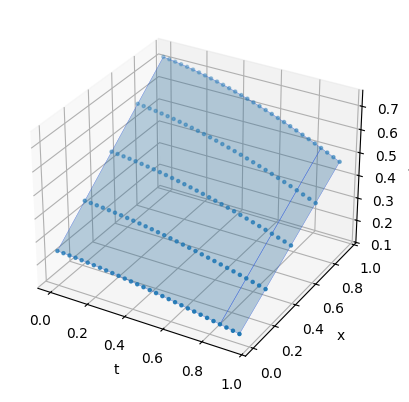

In [ ]:
solution_2 = job_2.result()

# Plot the solution of the second simulation job_2
_ = plt.figure()
ax = plt.axes(projection="3d")

# plot the solution using the 3d plotting capabilities of pyplot
t, x = np.meshgrid(solution_2["samples"]["t"], solution_2["samples"]["x"])
ax.plot_surface(
    t,
    x,
    solution_2["functions"]["u"],
    edgecolor="royalblue",
    lw=0.25,
    rstride=26,
    cstride=26,
    alpha=0.3,
)
ax.scatter(t, x, solution_2, marker=".")
ax.set(xlabel="t", ylabel="x", zlabel="u(t,x)")

plt.show()

## Tutorial survey

Please take a minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience:

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_3BLFkNVEuh0QBWm)